In [1]:
import control.matlab as cnt
import numpy as np
from matplotlib import rcParams
from utils import create_output_dir, plot_bode, plot_response, plot_responses

from sippy import functionset as fset
from sippy import system_identification

rcParams["figure.figsize"] = (9.0, 5.0)
output_dir = create_output_dir("test_armax.ipynb")
np.random.seed(0)

## Define sampling time and Time vector

In [2]:
sampling_time = 1  # [s]
end_time = 400  # [s]
npts = end_time // sampling_time + 1
Time = np.linspace(0, end_time, npts)

## Define pseudo random binary sequence as input signal and white noise as noise signal

In [3]:
# make input signal
switch_probability = 0.08  # [0..1]
Usim, _, _ = fset.GBN_seq(npts, switch_probability)

# make noise for input signal
white_noise_variance = [0.005]
e_t = fset.white_noise_var(Usim.size, white_noise_variance)[0]

## Define the system

### Numerator of noise transfer function has only one root: nc = 1

In [4]:
NUM_H = [
    1.0,
    0.3,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
]

### Common denominator between input and noise transfer functions has 4 roots: na = 4

In [5]:
DEN = [
    1.0,
    -2.21,
    1.7494,
    -0.584256,
    0.0684029,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
]

### Numerator of input transfer function has 3 roots: nb = 3

In [6]:
NUM = [1.0, -2.07, 1.3146]

### Define transfer functions

In [7]:
g_sample = cnt.tf(NUM, DEN, sampling_time)
h_sample = cnt.tf(NUM_H, DEN, sampling_time)
print("g()")
display(g_sample)
print("h()")
display(h_sample)

g()


TransferFunction(array([ 1.    , -2.07  ,  1.3146]), array([ 1.       , -2.21     ,  1.7494   , -0.584256 ,  0.0684029,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ]), 1)

h()


TransferFunction(array([1. , 0.3, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. ]), array([ 1.       , -2.21     ,  1.7494   , -0.584256 ,  0.0684029,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ]), 1)

## Time responses

### Input reponse

In [8]:
Y1, Time, Xsim = cnt.lsim(g_sample, Usim, Time)

/opt/pysetup/.venv/lib/python3.12/site-packages/control/timeresp.py:1083: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  warnings.warn(


### Noise response

In [9]:
Y2, Time, Xsim = cnt.lsim(h_sample, e_t, Time)

## Compute total output 
$$Y_t = Y_1 + Y_2 = G.u + H.e$$

In [10]:
Ytot = Y1 + Y2
Utot = Usim + e_t

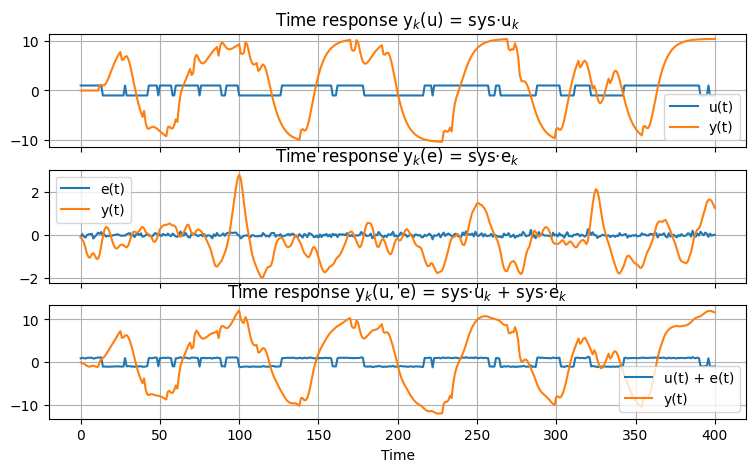

In [11]:
fig = plot_responses(
    Time,
    [Usim, e_t, Utot],
    [Y1, Y2, Ytot],
    ["u", "e", ["u", "e"]],
)

fig.savefig(output_dir + "/responses.png")

## Perform system identification from collected data

In [12]:
sys_id = system_identification(
    Ytot,
    Usim,
    "ARMAX",
    IC="BIC",
    na_ord=(2, 5),
    nb_ord=(1, 5),
    nc_ord=(0, 2),
    delays=(10, 13),
    max_iter=1000,
)

/app/sippy/__init__.py:211: UserWarning: no correct information criterion selected, using 'None'
  warn("no correct information criterion selected, using 'None'")


## Check that output of the identified system is consistent

In [13]:
Y_id1, Time, Xsim = cnt.lsim(sys_id.G, Usim, Time)
Y_hid1, Time, Xsim = cnt.lsim(sys_id.H, e_t, Time)
Y_idTot = Y_id1 + Y_hid1

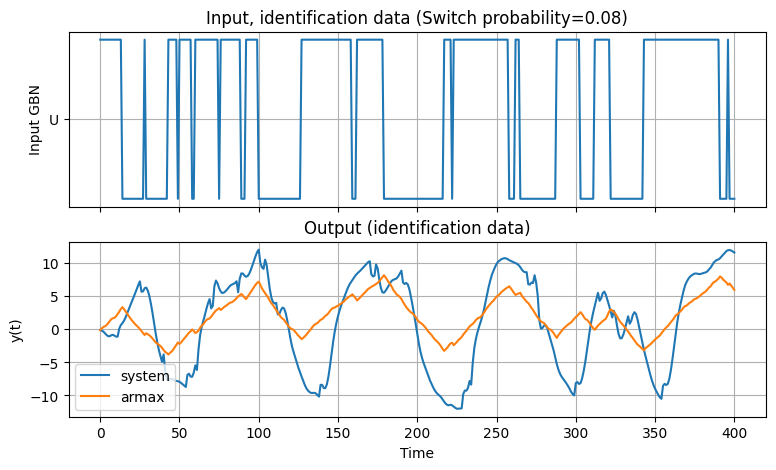

In [14]:
fig = plot_response(
    Time,
    Usim,
    [Ytot, Y_idTot],
    legends=[["U"], ["system", "armax"]],
    titles=[
        "Input, identification data (Switch probability=0.08)",
        "Output (identification data)",
    ],
)
fig.savefig(output_dir + "/system_consistency.png")

# Validation of the identified system: 
## Generate new time series for input and noise

In [15]:
switch_probability = 0.07  # [0..1]
input_range = [0.5, 1.5]
U_valid, _, _ = fset.GBN_seq(npts, switch_probability, Range=input_range)
white_noise_variance = [0.01]
e_valid = fset.white_noise_var(U_valid.size, white_noise_variance)[0]

## Compute time responses for true system with new inputs

In [16]:
Yvalid1, Time, Xsim = cnt.lsim(g_sample, U_valid, Time)
Yvalid2, Time, Xsim = cnt.lsim(h_sample, e_valid, Time)
Ytotvalid = Yvalid1 + Yvalid2

## Compute time responses for identified system with new inputs

In [17]:
Yidvalid1, Time, Xsim = cnt.lsim(sys_id.G, U_valid, Time)
Yidvalid2, Time, Xsim = cnt.lsim(sys_id.H, e_valid, Time)
Yidtotvalid = Yidvalid1 + Yidvalid2

## Check responses are almost equal

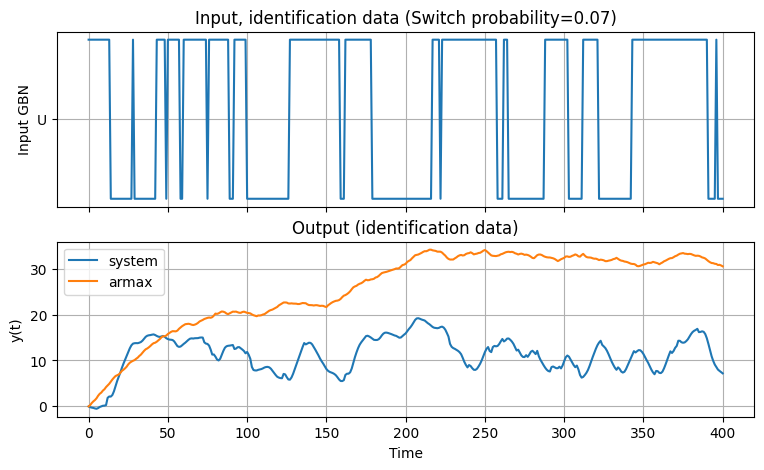

In [18]:
fig = plot_response(
    Time,
    Usim,
    [Ytotvalid, Yidtotvalid],
    legends=[["U"], ["system", "armax"]],
    titles=[
        "Input, identification data (Switch probability=0.07)",
        "Output (identification data)",
    ],
)
fig.savefig(output_dir + "/system_validation.png")

/opt/pysetup/.venv/lib/python3.12/site-packages/control/lti.py:114: UserWarning: __call__: evaluation above Nyquist frequency
  warn("__call__: evaluation above Nyquist frequency")
/opt/pysetup/.venv/lib/python3.12/site-packages/control/freqplot.py:435: FutureWarning: bode_plot() return value of mag, phase, omega is deprecated; use frequency_response()
  warnings.warn(
/opt/pysetup/.venv/lib/python3.12/site-packages/control/lti.py:114: UserWarning: __call__: evaluation above Nyquist frequency
  warn("__call__: evaluation above Nyquist frequency")
/opt/pysetup/.venv/lib/python3.12/site-packages/control/freqplot.py:435: FutureWarning: bode_plot() return value of mag, phase, omega is deprecated; use frequency_response()
  warnings.warn(


/opt/pysetup/.venv/lib/python3.12/site-packages/control/lti.py:114: UserWarning: __call__: evaluation above Nyquist frequency
  warn("__call__: evaluation above Nyquist frequency")
/opt/pysetup/.venv/lib/python3.12/site-packages/control/freqplot.py:435: FutureWarning: bode_plot() return value of mag, phase, omega is deprecated; use frequency_response()
  warnings.warn(
/opt/pysetup/.venv/lib/python3.12/site-packages/control/lti.py:114: UserWarning: __call__: evaluation above Nyquist frequency
  warn("__call__: evaluation above Nyquist frequency")
/opt/pysetup/.venv/lib/python3.12/site-packages/control/freqplot.py:435: FutureWarning: bode_plot() return value of mag, phase, omega is deprecated; use frequency_response()
  warnings.warn(


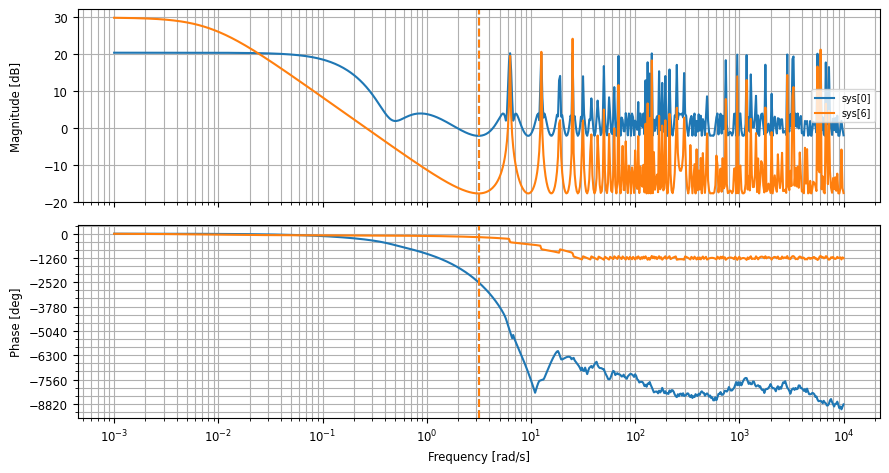

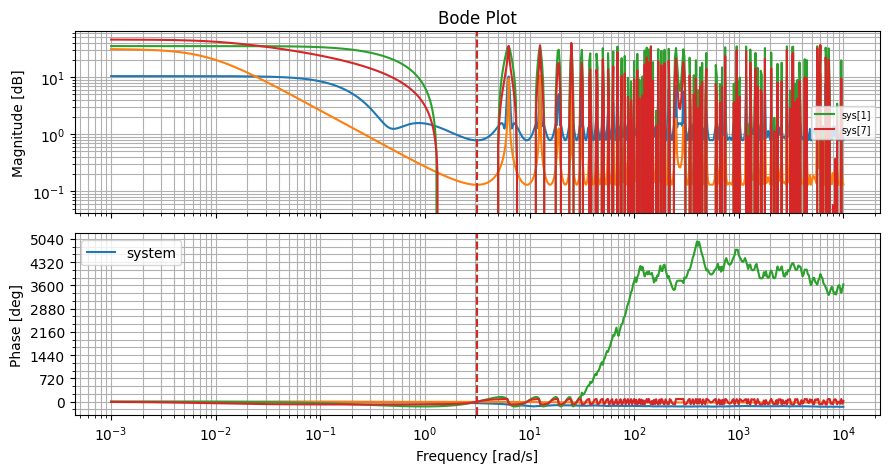

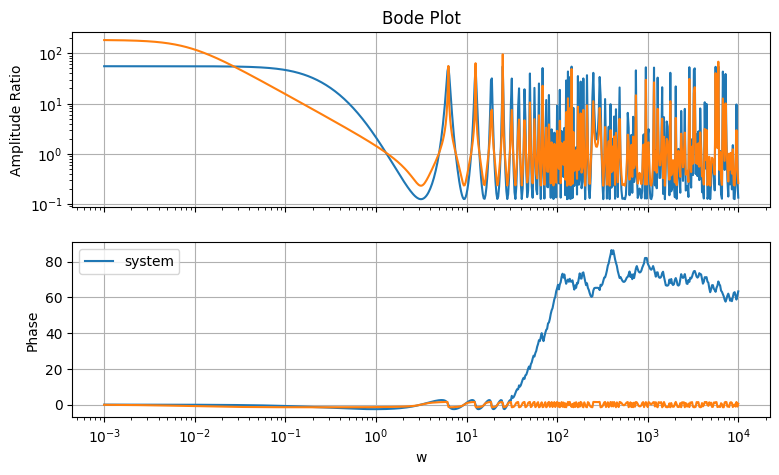

In [19]:
W_V = np.logspace(-3, 4, num=701)
for tf in ["G", "H"]:
    syss_tfs = [
        locals()[f"{tf.lower()}_sample"],
        getattr(sys_id, tf),
    ]
    mags, fis, oms = zip(*[cnt.bode(sys, W_V) for sys in syss_tfs])

    fig = plot_bode(
        oms[0],
        mags,
        fis,
        ["system"],
    )
    fig.savefig(output_dir + f"/bode_{tf}.png")